# Classification de pièces jointes avec un modèle CNN
## Cadre du notebook
Ce notebook est un tutoriel vise à présenter plusieurs éléments :
- le cadre théorique et les architectures de modèles CNN
- l'implémentation sous Keras et les différents hyper-paramètres des modèles 
- des benchmarks publics des architectures et l'idée sous-jacente à chacune
- l'application à un jeu de données trop important pour tenir en RAM

Dans une 2e partie (ou un 2e notebook?), nous présenterons quelques fonctionnalités essentielles dans le cadre d'un usage "pratique" : 
- l'augmentation de données, et la création d'un générateur personnalisé adapté à des besoins spécifiques
- la possibilité de modifier "à la volée" la fonction de calibrage pour lire les données sur le disque
- Une application à jeu de données réel sur la catégorisation des emails

## Présupposé
Ce notebook considère que le lecteur est familier avec l'architecture des réseaux de neurones du type *MultiLayer Percerptron* (MLP) (composés de couches "denses"). 

# Un peu de théorie
Les *Convolutionnal Neural Networks* (CNN) sont une classe de modèle spécifiquement créé pour effectuer de la classification d'images, et qui s'avèrent particulièrement performant pour cela. Nous ne nous intéressons ici qu'aux données spatiales (images), et donc nous ne parlons que des couhes keras finissant par le suffixe "2D".

## Couche de convolution

Le principe de la convolution  est de créer des "filtres" de convolution, appelés noyaux (*kernels* en anglais) qui vont s'appliquer à différentes zones spatiales de l'image. En effet, les images étant en 2 dimensions, on suppose que les pixels autour d'un pixel donné portent de l'information pour le décrire. L'intuition derrière cela est que ces filtres vont capter des éléments invariants  invariants (des "formes")  et tester si ces formes se retrouvent à différents endroits de l'image.

### Paramètres
Les paramètres d'une couche de convolution (**Conv2D** dans keras) sont les suivants :
- **filters** (entier) : le nombre de filtres à entraîner dans la couche. Comme ces filtres sont initialisés aléatoirement, ils vont converger différemment et permettre de capter des "formes" différentes. 
    - un proxy courant est de le prendre au moins supérieur à *hauteur x largeur (x3 si image en couleur)* avec kernel_size = (hauteur, largeur)) afin d'éviter la perte d'information d'après [ici](https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function)
    - il vaut mieux penser en "volume" qu'en nombre de filtres : par exemple, après une couche de *pooling* (2,2), la dimension a été divisée par 4, donc doubler le nombre de filtre dans la couche suivante permet de ne diviser la dimension que par 2. De manière générale, les architectures récentes essayent de ne pas diminuer la dimension par un facteur supérieur à 2 pour éviter une perte trop brusque d'information.
- **kernel_size** (un tuple (hauteur, largeur)) : les dimensions d'un filtre (i.e du rectangle) en nombre de pixel. De manière générale :
    - Les valeurs usuelles de *kernel_size* sont comprises entre (1,1) et 5,5) et l'on retient des formes "carrées" sauf cas spécifique
    - Des tailles de noyaux "petits" améliorent en général la performance mais nécessitent plus de couches cachées, ce qui augmentent beaucoup le temps de calcul.
    - Si les images sont en couleur (*rgb*) plutôt qu'en noir et blanc (*grayscale*), les filtres ont alors automatiquement une 3e dimension de taille 3, ce qui fait que ce sont des parallélépipèdes plutôt que des rectangles.
    - Des convolutions 1x1 ont parfois un intérêt mais sont souvent hautement corrélés, il est donc courant de les combiner avec un *dropout*
- **stride**  (un entier, 1 très souvent): ce paramètre correspond au "pas" avec lequel le noyau est déplacé horizontalement et verticalement à chaque application. En pratique :
    - le stride utilisé est quasiment systématiquement de valeur 1
    - dans certains cas, le stride est augmenté pour réduire la dimension, mais rarement au dela de 2.
- **padding** (*same* ou *valid*): ce paramètre définit la politique de gestion des "effets de bord" lorsque le filtre s'approche des bords de l'image. Le mode *valid* ne considère que les sous-ensembles de l'image sur lesquels le filtre peut s'appliquer en entier. Le mode *same* permet de déborder de l'image afin de préserver la dimension de l'image après l'application du filtre. Préserver la dimensions permet de ([source](https://stats.stackexchange.com/questions/246512/convolutional-layers-to-pad-or-not-to-pad)): 
    - ne pas se préoccuper de la forme du tenseur lorsque l'on empile des couches successives
    - créer des réseaux plus profonds (sinon la dimension diminue rapidement)
    - améliorer la performance en tenant compte des pixels sur les bords de l'image
- **autres paramètres** : les autres paramètres seront discutés ultérieurment et font éventuellement l'objet de *tuning* mais sont rarement utilisés en première approche. 

### Visualisation des effets de différents paramètres
On considère une image de (hauteur, largeur) = (5, 5) en pixels

#### Exemple 1 : Application d'un filtre de kernel_size = (2,2)
![default_cnn](figures/default_cnn.gif)

#### Exemple 2 : Ajout de *padding* pour préserver la dimension après application du filtre
![cnn_padding_same](figures/cnn_padding_same.gif)

#### Exemple 3 : Ajout d'un *stride* de 2  pour diviser la dimension
![cnn_stride2](figures/cnn_stride2.gif)

#### Résultat de l'application d'un filtre de convolution
- On applique un filtre 3x3 (padding = "valid", stride = 1) sur une image représentant un 9 de taille 8 x 5.
![resultat_convolution](figures/resultat_convolution.png)
- Intuitivement, ce filtre détecte des traits horizontaux dans l'image.
- Sans padding, la dimension de l'image a été réduite

### Calcul du nombre de paramètres de la couche
Le nombre de paramètres à calibrer pour la couche dans son ensemble est : 
$\underbrace{filters}_{\text{nombre de filtres}} \times \underbrace{kernel\_size[1]}_{\text{hauteur des filtres}}\times \underbrace{kernel\_size[2]}_{\text{largeur des filtres}}\times \underbrace{3}_{\text{profondeur des filtres (si couleur)}}$

### Forme de l'output
$largeur\_output=\frac{largeur\_input−largeur\_kernel+2\times padding}{stride}+1$

La même formule s'applique pour la hauteur

## Couche de *Pooling*
Le principe d'une couche de pooling est de réduire la dimension de l'image en ne gardant que les pixels d'intesité maximale dans une zone donnée. Cette approche est critiquée dans des papiers récents, qui proposent de réduire la dimension en utilisant une couhe de convolution avec un "stride" supérieur à 1 pour réster cohérent avec l'intuition sous-jacente au CNN qui consiste à "calibrer" ces filtres plutôt qu'à définir soi-même (ici, l'usage de la fonction max ou mean).

### Paramètres
L'idée étant d'appliquer des filtres, les paramètres sont similaires à ceux du CNN : 
- **pool_size** (hauteur, largeur) : les dimensions du filtre
- **strides** : le pas de décalage du filtre après chaque application
- **padding** : faut-il ajouter des 0 sur les bords de l'image pour préserver sa dimension?

*Note : il existe 2 fonctions principales : MaxPooling2D qui prend le maximum de chaque zone filtrée, et AveragePooling2D qui en prend la moyenne*

#### Exemple 3 : Ajout d'un *stride* de 2  pour diviser la dimension
![resultat_pooling](figures/resultat_pooling.png)

## Fonctions d'activation
La fonction d'activation permet de rendre le modèle non linéaire (i.e. de créer des effets de "seuillage" pour déterminer si un neurone doit être activé ou non). Pour la couche de convolution, elle s'applique du résultat obtenu après application des filtres CNN. 

De manière générale, les fonctions les plus standards sont les suivantes : 
- sigmoïde et hyperbolique : fortement déconseillée car ce sont des fonctions saturées, i.e. "lissées" de manière a ne pas atteindre 0 rapidement. En pratique, cela diminue le gradient lors de la backpropagation et diminue fortement la perfomance du modèle.
- $RELU(x) = max(0,x)$ est plus efficace computationnellement, rend la convergence plus rapide et n'est pas saturée, ce qui en fait un choix courant par défaut. 
- Des variations autour de RELU (ELU, Leaky RELU, Maxout) permette de lisser la fonction autour de 0 et rendent parfois le modèle plus robuste au bruit. Elles peuvent être testées ultérieurement.

# Optimisation numérique
## Notions élémentaires
Le calibrage d'un réseau de neurones se fait par optimisaiton successive des matrices de poids dans chaque couche. La mise à jour de ces poids se fait par *backpropagation*, i.e de proche en proche depuis la dernière couche de réseau en utilisant la formule de composition des dérivées. Le calcul se fait sur la fonction de perte et dépend des fonctions d'activations de chaque couche.

L'optimisation fait intervenir [différents paramètres](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9): 
- Une **epoch** correspond à un passage de l'intégralité du dataset dans le réseau (forward et backward)
- Un **batch** correspond à un sous-ensemble de données. De manière générale, on découpe une *epoch* en plusieurs batchs de taille fixée (**batch_size**). Les données d'un même batch vont être passées simultanément au réseau pour l'optimisation
- Une **iteration** est le nombre de batch nécessaire pour effectuer une *epoch*.

## Pourquoi diviser une epoch en plusieurs batchs? : 
- Les données sont souvent trop volumineuses en mémoire pour être passées simultanément
- Les papiers de recherche s'accordent sur le fait qu'une taille de batch "intermédiaire" (16 à 1024, très dépendante du problème) permet une meilleure optimisation. Un batch trop grand lisse le graident et ne permet pas de tenir compte de spécificités locales ; un batch trop petit le rend trop volatile et rend plus difficle la convergence.

## Les optimiseurs courants
De [très nombreuses méthodes d'optimisation](http://ruder.io/optimizing-gradient-descent/) existent pour calibrer les réseaux de neurones. En résumé, [l'heuristique suivante](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) est conseillée  :
- commencer avec Adam pour converger plus vite en tunant les paramètres
- Utiliser SGD ou RMSprop *a posteriori* une fois l'architecture fixée.

**Remarque :** *SGD est problématique : le problème mal conditionné, i faut donc un $\eta$ très faible pour garantir la convergence. le problème est que cela rend l'apprentissage très lent. De plus, il n'arrive quasiment jamais à un point critique (minimum ou point selle), même local! Dans les faits, SGD a été très critiqué mais il y a un regain d'intérêt récent. car même s'il performe moins bien sur la base d'entrainement, il permet parfois de mieux étendre.*


# Application sur Keras
## Architecture du modèle

Comme les modèles CNN en général, l'idée est d'empiler plusieurs couches pour créer des blocks en répétant des empilements de couches selon le motif (Convolution, Convolution, Pooling). Les points clés de construction des blocs sont les suivants : 
- La première couche de chaque block a un paramètre de *padding* pour conserver la dimension
- Le nombre de filtres dans un même block est constant
- Une couche de *Dropout* est ajoutée après chaque couche de *pooling*. Cette couche sert à déconnecter aléatoirement un pourcentage des neurones pendant l'apprentissage. Ceci permet de régulariser l'apprentissage et d'éviter le sur-apprentissage.

Sur l'architecture en général : 
- après une couche de pooling 2x2, la taille de la sortie est divisée par 4 : le nombre de filtres est doublé pour compenser la perte d'information.
- le dernier block sert à effectuer la prédiction. Pour cela:
    - le tenseur 3D de la couche précédente est transformé en vecteur en 1 dimension grace une couche "Flatten()". 
    - Une couche dense avec de nombreux neurones agrège ces données
    - Le *Dropout* est traditionnelement plus élevé pour les couches denses qui sont plus sujettes au sur-apprentissage
    - Une dernière couche "dense" contenant exactement le même nombre de neurones que le nombre de classes à prédire va effectuer la classification. L'activation à retenir dépend de la tâche : "sigmoid" pour une classification binaire (ou multi-label, nous y reviendrons), "softmax" pour une classification multi-classe.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

def create_small_vgg(num_classes, activation, img_height, img_width, nb_channels, final_activation):
    # from keras exemple : https://keras.io/examples/cifar10_cnn/

    model = Sequential()
    # first convolutional layers
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = activation, input_shape = (img_height, img_width, nb_channels)))
    model.add(Conv2D(32, (3, 3), padding = 'valid', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))


    # second convolution block
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(Conv2D(64, (3, 3), padding = 'valid', activation = activation))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # output
    model.add(Flatten())
    model.add(Dense(512, activation = activation))
    model.add(Dropout(0.5))  # high dropout to deal with large dense value
    model.add(Dense(num_classes, activation = final_activation))

    return model

Using TensorFlow backend.


model.add(Conv2D(32, (3, 3), padding = 'same', activation = activation, input_shape = (img_height, img_width, nb_channels)))
On applique ici 32 filtres

## Choix de l'optimiseur

Pour des raisons de vitesse de convergence, nous nous concentrons sur *Adam* ici.

Le parametre de *decay* est fixé de manière à faire le *learning rate* décroître à chaque *epoch* 

In [2]:
from keras.optimizers import adam
def create_optimizer(init_lr, nb_epochs):
    opt = adam(lr = init_lr, decay = init_lr / nb_epochs)
    return opt

## Présentation des données

Le jeu de données utilisé est [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Ce jeu contient des images à un format 32 x 32. Les images sont réparties en 10 catégories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) de la façon suivante :
- La base de train contient exactement $5 000$ images de chaque catégorie, soit $50 000$ images. 
- La base de test contient exactement $1 000$ images de chaque catégorie, soit $10 000$ images.

In [3]:
# First, we load the data. On first call, this data will be downloaded from the website quoted above.
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant

In [ ]:
x_train=

In [4]:
# For convenience and pretty display, we create a dictionnary which maps categories names and number (they are encoded as number between 0-9).
levels_map = dict(zip(range(10), ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]))

Le code ci-dessous permet de visualiser les données (changer IMG_NUMBER ou IMG_DISPLAY_SIZE pour modifier l'affichage) : 

Label : 'automobile'


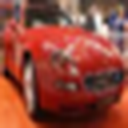

In [5]:
# import PIL  # not necessary to import, but the packages should be loaded to enable keras 'array_to_img' to work.
from PIL import Image
from keras.preprocessing.image import array_to_img

IMG_DISPLAY_SIZE = 128
IMG_NUMBER = 5

# display image with label
print("Label : '{}'".format(levels_map[y_train[IMG_NUMBER][0]]))
array_to_img(x_train[IMG_NUMBER,:,:,:]).resize((IMG_DISPLAY_SIZE, IMG_DISPLAY_SIZE), Image.ANTIALIAS)

## Entrainement du modèle

In [6]:
# CONSTANTES 
## pour le modèle
NUM_CLASSES = len(levels_map.keys())
ACTIVATION, FINAL_ACTIVATION = "relu", "softmax"
IMG_HEIGHT, IMG_WIDTH, NB_CHANNELS = 32, 32, 3

# Pour le modèle
LOSS_FUNCTION = 'categorical_crossentropy' # 'binary_crossentropy' for multilabel classification, 'categorical_crossentropy'
METRICS = ['accuracy']

## pour l'optimisation
NB_EPOCHS = 30
BATCH_SIZE = 32
INIT_LR = 1e-4

On reformate les labels pour les mettre à un format "tableau" (valant 1 si le label est associé à la classe et 0 sinon). Cela sera utile surtout dans le cas "multilabel" où on autorisera une même image à avoir plusieurs labels.

In [7]:
from keras.utils import to_categorical
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

De même, on renormalise les pixels entre 0 et 1.

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.
x_test /= 255.

On commence par créer tous les instances d'objects nécessaires au modèle :

In [9]:
model = create_small_vgg(num_classes = NUM_CLASSES,
                         activation = ACTIVATION,
                         img_height = IMG_HEIGHT,
                         img_width = IMG_WIDTH,
                         nb_channels = NB_CHANNELS,
                         final_activation = FINAL_ACTIVATION)

opt = create_optimizer(init_lr = INIT_LR,
                       nb_epochs = NB_EPOCHS)

# the model must be compiled
model.compile(loss = LOSS_FUNCTION,
              optimizer = opt,
              metrics = METRICS)

On peut visualiser l'architecture du modèle obtenu. Quelques explications détaillées sur les résultats obtenus : 
- La première couche de convolution applique 32 filtres de taille 3 x 3 sur une image en couleurs (donc la profondeur des filtres = 3). De plus chaque filtre possède un paramètre de biais, soit 32 paramètres supplémentaires : 
    - Nombre de paramètres = $\underbrace{32}_{\text{nombres filtres}} \times \underbrace{3}_{\text{hauteur filtre}}\times \underbrace{3}_{\text{largeur filtre}}\times \underbrace{3}_{\text{profondeur filtre}}  + \underbrace{32}_{\text{biais}} = 896$ 
    - Forme de la sortie = $\underbrace{32}_{\text{hauteur de l'image d'origine}} \times \underbrace{32}_{\text{largeur de l'image d'origine}} \times \underbrace{32}_{\text{Nombre de filtres}}$

Les dimensions de l'image d'origine sont identiques car le paramètre $padding = same$ implique la conservation des dimensions  

- Pour la deuxième couche : 
    - Nombre de paramètres = $32 \times 3\times 3 \times 32 + 32 = 9248$ (la profondeur des filtres est le nombre de filtres de la couche précédente)
    - Forme de la sortie : Les dimensions de l'image d'origine (hauteur et largeur) diminuent en l'absence de padding (le stride est de 1 et la dimension du filtre de 3 sur chaque dimension, donc cela conduit à une diminution de 2 *pixels* sur chaque dimension).
    
- ...

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

Pour alimenter le modèle lors de l'entraînement, nous allons utiliser un générateur de données. Cet objet est une boucle infinie qui renvoie des batch de données ainsi que les labels associés. Cet objet va permettre d'appliquer des tranformations sur les données "à la volée" poiur les fournir au modèle.

Dans un premier temps, nous nous contentons de changer l'échelle des pixels pour les remettre entre 0 et 1 (au lieu de [0;255]).

_**Note** : pour des questions de rapidité d'exécution dans ce notebook, nous limitons l'entraînement à 1000 images et à peu d'epochs ce qui donne des résultats très sous-optimaux._

In [11]:
model.fit(x_train[0:1000,:,:,:],
          y_train[0:1000],
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCHS,
          validation_data=(x_test[0:1000,:,:,:], y_test[0:1000]),
          shuffle=True)

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 6s 6ms/step - loss: 2.3147 - acc: 0.1160 - val_loss: 2.2911 - val_acc: 0.1170
Epoch 2/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.2894 - acc: 0.1370 - val_loss: 2.2833 - val_acc: 0.1500
Epoch 3/30
1000/1000 [==============================] - 4s 4ms/step - loss: 2.2750 - acc: 0.1290 - val_loss: 2.2661 - val_acc: 0.1640
Epoch 4/30
1000/1000 [==============================] - 4s 4ms/step - loss: 2.2414 - acc: 0.1570 - val_loss: 2.2271 - val_acc: 0.2200
Epoch 5/30
1000/1000 [==============================] - 5s 5ms/step - loss: 2.1550 - acc: 0.1860 - val_loss: 2.1426 - val_acc: 0.2290
Epoch 6/30
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0695 - acc: 0.2350 - val_loss: 2.0814 - val_acc: 0.2400
Epoch 7/30
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0165 - acc: 0.2490 - val_loss: 2.0230 - val_acc: 0.2840
Epoch 8/30
100

Il est possible de tracer l'évolution de l'*accuracy* au cours de l'entraînement :

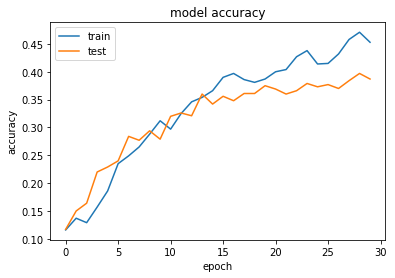

In [15]:
import matplotlib.pyplot as plt
plt.plot(model.history.history["acc"])
plt.plot(model.history.history["val_acc"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

On constate que la métrique d'évaluation a stagné sur la base de test, quoi que la convergence ne soit pas encore complète. Il faut toutefois vérifier si le modèle performe de la même façon sur toutes les classes.

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_contingency(y_true, y_pred, labels = None):
    contingency_matrix = confusion_matrix(y_true = y_true, y_pred = y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(contingency_matrix, vmin = 0, vmax = 1.5 * np.max(contingency_matrix), cmap = "Reds")

    # axes
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    if labels is not None:
        ax.set_xticklabels(labels.values())
        ax.set_yticklabels(labels.values())
    ax.set_xlabel("predicted", fontweight='bold')
    ax.set_ylabel("actual", fontweight='bold')

    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right",
             rotation_mode = "anchor")

    # text annotation
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, contingency_matrix[i, j],
                    ha = "center", va = "center", color = "black")
    ax.set_title("Contingency table of model predictions")

    fig.tight_layout()
    plt.show()

    return None

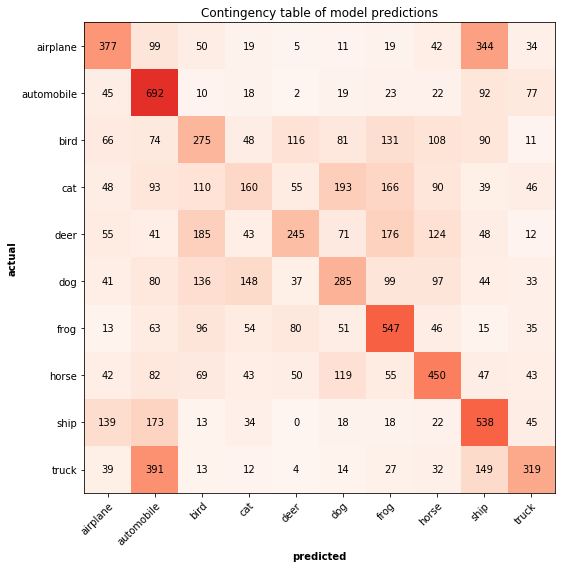

In [14]:
# get predictions on test
predictions = model.predict_classes(x_test)

# plot on data
plot_contingency(y_true = np.argmax(y_test, axis = 1),
                 y_pred = predictions, 
                labels = levels_map)

De manière intéressante, les résultats sont assez conformes à l'intuition humaine. Par exemple:
- le modèle confond les voitures avec les camions, dans une moindre mesure avec les avions et les bateaux, et très peu avec les différents animaux.
- les deux classes les plus confondues entre elles sont les chats et les chiens qui sont également les plus similaires "visuellement" pour un humain.

# Foire aux questions : quelques problématiques plus réalistes...
- [Q1 : Que faire si j'ai très peu de données?](#Q1-:-Que-faire-si-j'ai-très-peu-de-données?)
- [Q2 : Que faire si les données ne tiennent pas en RAM?](#Q2-:-Que-faire-si-les-données-ne-tiennent-pas-en-RAM?)
- [Q3 : Comment faire les données peuvent être multi-labellisées?](#Q3-:-Comment-faire-les-données-peuvent-être-multi-labellisées?)
- [Q4 : Que faire si mon modèle ne semble pas s'améliorer sur la base de train?](#Q4-:-Que-faire-si-mon-modèle-ne-semble-pas-s'améliorer-sur-la-base-de-train?)
- [Q5 : Que faire si mon modèle ne semble pas s'améliorer sur la base de test ?](#Q5-:-Que-faire-si-mon-modèle-ne-semble-pas-s'améliorer-sur-la-base-de-test-?)
- [Q6 : Mon modèle est très lent à s'entraîner, que faire?](#Q6-:-Mon-modèle-est-très-lent-à-s'entraîner,-que-faire?)
- [Q7 : Comment choisir l'architecture du modèle?](#Q7-:-Comment-choisir-l'architecture-du-modèle?)
- [Q8 : Comment exécuter des fonctions personnelles pendant l'entraînement du modèle?](#Q8-:-Comment-exécuter-des-fonctions-personnelles-pendant-l'entraînement-du-modèle?)
- [Q9 : Comment reprendre l'entraînement à partir d'un point donné?](#Q9-:-Comment-reprendre-l'entraînement-à-partir-d'un-point-donné?)
- [Q10 : Comment interpréter et visualiser une prédiction du réseau?](#Q10-:-Comment-interpréter-et-visualiser-une-prédiction-du-réseau?)
- [Q11 : Comment créer un modèle avec des empilements de couches non linéaires?](#Q11-:-Comment-créer-un-modèle-avec-des-empilements-de-couches-non-linéaires?)

## [Q1 : Que faire si j'ai très peu de données?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

[Ressources](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

**_Problème :_** Les modèles de *deep learning* sont sur-paramétrés, ce qui pose des problèmes d'identification. En particulier, ces modèles nécessitent de très nombreuses données pour converger. Par exemple, dans l'exemple précédent nous n'utilisons que 1000 images pour l'entraînement, ce qui est très insuffisant pour permettre au modèle de converger. 

**_Solution :_** Pour alimenter le modèle lors de l'entraînement, nous allons utiliser un générateur de données. Cet objet est une boucle infinie qui renvoie des batch de données ainsi que les labels associés. Cet objet va permettre d'appliquer des tranformations sur les données "à la volée" pour les fournir au modèle et le rendre plus resistant au bruit.

**_Implémentation :_** Le plus simple est d'utiliser le générateur interne à Keras. Il est aussi possible de crééer son propre générateur. 

In [16]:
# reload data (to avoid corruption with previous treatments)
from keras.datasets import cifar10
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# recreate model to avoid continuing training
model = create_small_vgg(num_classes = NUM_CLASSES,
                         activation = ACTIVATION,
                         img_height = IMG_HEIGHT,
                         img_width = IMG_WIDTH,
                         nb_channels = NB_CHANNELS,
                         final_activation = FINAL_ACTIVATION)

opt = create_optimizer(init_lr = INIT_LR,
                       nb_epochs = NB_EPOCHS)

# the model must be compiled
model.compile(loss = LOSS_FUNCTION,
              optimizer = opt,
              metrics = METRICS)

In [17]:
# create image generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255, # rescale "on the fly"
    rotation_range = 30, # rotate images in the range [-rotation_range, rotation_range]
    width_shift_range = 0.1, # translate  to the left or the right 
    height_shift_range = 0.1, # translate to the bottom or top
    shear_range = 0.1, # shear transformatio, see wikipedia
    zoom_range = 0.3, # zoom percentage of the image
    fill_mode = "nearest") # what if the new image has pictures out of the input size
# zca whitening? -> need to be fitted

In [18]:
# create the generator (i;e the iterable which loops infinitely and returns batch and labels)
train_generator = datagen.flow(x_train[0:1000,:,:,:], y_train[0:1000], batch_size = BATCH_SIZE)
test_generator = datagen.flow(x_test[0:1000,:,:,:], y_test[0:1000], batch_size = BATCH_SIZE)

*Aparté* : à quoi correspondent les images générés par le générateur? 

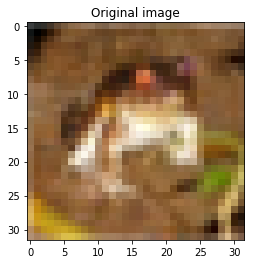

In [19]:
# FOR INFORMATION : what does the generator do?
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib.pyplot import subplots, imshow

NB_GENERATED_IMGS = 10
NB_IMGS_BY_ROW = 5


imshow(array_to_img(x_train[0,:,:,:]))
plt.title("Original image")

fig, axes = subplots(nrows= NB_GENERATED_IMGS//NB_IMGS_BY_ROW, ncols=NB_IMGS_BY_ROW, figsize=(20,10))
fig.suptitle("Generated_images")
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i=0

for batch in datagen.flow(x_train[0:1,:,:,:], batch_size=1): #note : we use a slice (0:1) to preserve the 4-dimension shape of a batch, if we use just 0 the shape would be 3D (32,32,3) 
    axes[i//NB_IMGS_BY_ROW, i%NB_IMGS_BY_ROW].imshow(array_to_img(batch[0,:,:,:]))
    i+=1
    if i==NB_GENERATED_IMGS: # stop criterion for the infinite loop
        break

*Fin de l'aparté*

In [20]:
# fit the model
model.fit_generator(generator = train_generator,
                    steps_per_epoch = train_generator.n // BATCH_SIZE,
                    validation_data = test_generator,
                    validation_steps = test_generator.n // BATCH_SIZE,
                    epochs = NB_EPOCHS,
                    workers = 7, 
                    use_multiprocessing = False, # known bug with True
                    verbose = 1, # 0 -no printing, 1- details for each iteration, 2-details only for epochs
                    shuffle = True)  # WARNING : if shuffle = False with the generator, same batch is yielded at each loop!

Epoch 1/30
31/31 [==============================] - 5s 170ms/step - loss: 2.3022 - acc: 0.1008 - val_loss: 2.2904 - val_acc: 0.1129
Epoch 2/30
31/31 [==============================] - 4s 140ms/step - loss: 2.2875 - acc: 0.1140 - val_loss: 2.2797 - val_acc: 0.1353
Epoch 3/30
31/31 [==============================] - 4s 141ms/step - loss: 2.2711 - acc: 0.1352 - val_loss: 2.2542 - val_acc: 0.1312
Epoch 4/30
31/31 [==============================] - 4s 141ms/step - loss: 2.2001 - acc: 0.1775 - val_loss: 2.1573 - val_acc: 0.1829
Epoch 5/30
31/31 [==============================] - 4s 143ms/step - loss: 2.1223 - acc: 0.1927 - val_loss: 2.0868 - val_acc: 0.2665
Epoch 6/30
31/31 [==============================] - 4s 144ms/step - loss: 2.0715 - acc: 0.2028 - val_loss: 2.0589 - val_acc: 0.2211
Epoch 7/30
31/31 [==============================] - 4s 143ms/step - loss: 2.0206 - acc: 0.2629 - val_loss: 2.0156 - val_acc: 0.2438
Epoch 8/30
31/31 [==============================] - 4s 137ms/step - loss: 1.

Par rapport au modèle sans augmentation des données, l'entraînement est plus instable et plus lent (i.e. nécessite plus d'*epochs*) mais performe mieux et s'étend mieux aux données de validation.

## [Q2 : Que faire si les données ne tiennent pas en RAM?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

**_Problème :_** Sur des projets à grande échelle, les images peuvent être de résolution bien supérieures à celle de ce tutoriel ; de plus, elles peuvent être bien plus nombreuses. Dans ce cas, il est probable qu'il ne soit pas possible de charger le dataset de *training* dans la RAM, ce qui empêche d'éxecuter le code précédent.

**_Solution :_** L'idée est d'utiliser un générateur (cf. [Q1 : Que faire si j'ai très peu de données?](#Q1-:-Que-faire-si-j'ai-très-peu-de-données?)) qui génère les images en les lisant à la volée depuis le disque, ce qui permet de faire l'entraînement en ne chargeant au plus que *BATCH_SIZE* images en RAM.


**_Implémentation :_** La solution est très proche de celle présentée dans la Q1, mais: 
- les données doivent être toutes mises dans un dossier unique, avec des sous-dossiers dont les noms sont les labels à prédire, et chaque sous-dossier contient les images de ce label au format png. (*Note : On peut créer son propre générateur pour autoriser des formats de dossier différents*).
- il faut utiliser la fonction *flow_from_directory* pour générer les images.

In [21]:
# write the 1000 first images to disk to emulate the process
#from keras.preprocessing.image import array_to_img

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#for i in range(1000):
#    print(i)
#    array_to_img(x_train[i,:,:,:]).save("data/train/{0}/{0}_{1}.jpg".format(levels_map[y_train[i][0]], i))
#    array_to_img(x_test[i,:,:,:]).save("data/test/{0}/{0}_{1}.jpg".format(levels_map[y_test[i][0]], i))

In [22]:
# create the generator (i.e the iterable which loops infinitely and returns batch and labels)
# I created a folder cifar10_small_train with only the 100 first pictures of cifar10 train dataset
# for the validation generator, I used a different folder
train_generator = datagen.flow_from_directory(directory = "data/cifar10/train",
                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')
test_generator = datagen.flow_from_directory(directory = "data/cifar10/test",
                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [23]:
# fit the model
model.fit_generator(generator = train_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE, # note that the ".n" has become ".sample" comparing to "flow"
                    validation_data = test_generator,
                    validation_steps = test_generator.samples // BATCH_SIZE,
                    epochs = NB_EPOCHS,
                    workers = 7,
                    use_multiprocessing = False, # known bug with True
                    verbose = 1, # 0 -no printing, 1- details for each iteration, 2-details only for epochs
                    shuffle = True)  # WARNING : if shuffle = False with the generator, same batch is yielded at each loop!

Epoch 1/30
31/31 [==============================] - 5s 176ms/step - loss: 1.6741 - acc: 0.3931 - val_loss: 1.7961 - val_acc: 0.3407
Epoch 2/30
31/31 [==============================] - 4s 142ms/step - loss: 1.6874 - acc: 0.3900 - val_loss: 1.7721 - val_acc: 0.3719
Epoch 3/30
31/31 [==============================] - 4s 145ms/step - loss: 1.6507 - acc: 0.3801 - val_loss: 1.7701 - val_acc: 0.3605
Epoch 4/30
31/31 [==============================] - 5s 153ms/step - loss: 1.6882 - acc: 0.3881 - val_loss: 1.7909 - val_acc: 0.3440
Epoch 5/30
31/31 [==============================] - 4s 145ms/step - loss: 1.6560 - acc: 0.3991 - val_loss: 1.7566 - val_acc: 0.3647
Epoch 6/30
31/31 [==============================] - 4s 144ms/step - loss: 1.6662 - acc: 0.3810 - val_loss: 1.7585 - val_acc: 0.3709
Epoch 7/30
31/31 [==============================] - 5s 146ms/step - loss: 1.6362 - acc: 0.3952 - val_loss: 1.7663 - val_acc: 0.3543
Epoch 8/30
31/31 [==============================] - 5s 151ms/step - loss: 1.

Noter que l'exécution est plus lente lorsque les images sont lues depuis le disque. Ceci est largement aggravé si les images sont lourdes (haute résolution, couleur...). Dans ce cas, **il est largement conseillé de changer la taille des images AVANT l'entraînement**, et non pas à la volée (car dans ce cas l'image est lue avec sa taille originale ce qui peut être très lent.)

## [Q3 : Comment faire les données peuvent être multi-labellisées?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

[Ressources](https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/)

**_Problème :_** Le problème de classification présenté jusqu'ici est un problème "exclusif" au sens où :
- chaque image appartient à une seule ("au plus") classe
- chaque image appartient forcément ("au moins") à une classe
Concrètement, cela implique que:
- quelle que soit l'image que l'on lui présentera dans le futur, le modèle sera "forcé" de l'attribuer à une des 10 classes observées (au pire, il attribuera 10% de probabilité à chaque classe). Ceci peut ne pas être souhaité dans des cas d'applications réels : on veut souvent laisser la possibilité au modèle de ne pas se prononcer lorsqu'il a peu de certitudes (pour qu'un humain reprenne la main), par exemple si on lui présente un nouveau type de documents jamais observé auparavant.
- le modèle n'a pas la possibilité de prédire qu'une image possède des éléments de 2 classes (par exemple, comment réagirait notre modèle si on lui montrait une image avec une voiture et un avion?). Là encore, il peut être souhaitable dans des cas concrets de permettre au modèle de prédire plusieurs labels. 

**_Solution :_** L'idée est de considérer les différents problèmes comme étant un ensemble de nombreuses classification binaire " une classe versus les autres".

**_Implémentation :_** La solution consiste à changer les éléments suivants : 
- changer la fonction d'activation à "sigmoid" au lieu de "softmax" (comme pour les problèmes binaires)
- changer la fonction de perte du réseau à "binary_crossentropy" au lieu de "categorical_crossentropy"
- fournir des labels avec potentiellement plusieurs classes : pour cela, il est possible d'utiliser l'objet "MultiLabelBinarizer" de scikit-learn

In [24]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd
from PIL import Image

folder = "data/multilabel_vision/train"
img_height, img_width, channels = 32, 32, 3 # real image is 256x256 but it is too slow
filenames = os.listdir(folder)
data = np.ndarray(shape=(len(filenames), img_height, img_width, channels),
                     dtype=np.float32)
# read data
for i, file in enumerate(filenames):
    img = load_img(folder + "/" + file)
    img = img.resize((img_height, img_width), Image.ANTIALIAS)
    x = img_to_array(img)  
    x = x.reshape((img_height, img_width, 3))
    data[i,:,:,:] = x
    
# read labels 
df_labels = pd.read_csv(filepath_or_buffer="data/multilabel_vision/multilabel_vision_labels.csv",delimiter=",")
list_labels = [list(tag[0].split(" ")) for i, tag in enumerate(df_labels[["tags"]].values) if i<=3000]

In [25]:
# Step 1 : convert labels in multilabel array "multilabel"
from sklearn.preprocessing import MultiLabelBinarizer 

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(list_labels)    
print(y[0:5])
mlb.classes_

[[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]]


array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [26]:
NB_EPOCHS =10
IMG_HEIGHT, IMG_WIDTH, NB_CHANNELS = 32, 32, 3
NUM_CLASSES = len(mlb.classes_)
ACTIVATION = "relu"
INIT_LR = 1e-4
METRICS = ['accuracy']
BATCH_SIZE = 32
# step2 : create model with final sigmoid layer
model = create_small_vgg(num_classes = NUM_CLASSES,
                         activation = ACTIVATION,
                         img_height = IMG_HEIGHT,
                         img_width = IMG_WIDTH,
                         nb_channels = NB_CHANNELS,
                         final_activation = "sigmoid")

opt = create_optimizer(init_lr = INIT_LR,
                       nb_epochs = NB_EPOCHS)

#step 3 : use a binary crossentropy function
model.compile(loss = "binary_crossentropy",
              optimizer = opt,
              metrics = METRICS)

In [27]:
model.fit(data,
          y,
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCHS,
          shuffle=True)

Epoch 1/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.9914 - acc: 0.8441
Epoch 2/10
3001/3001 [==============================] - 10s 3ms/step - loss: 0.3433 - acc: 0.8807
Epoch 3/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.3123 - acc: 0.8899
Epoch 4/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.2980 - acc: 0.8940
Epoch 5/10
3001/3001 [==============================] - 10s 3ms/step - loss: 0.2918 - acc: 0.8965
Epoch 6/10
3001/3001 [==============================] - 10s 3ms/step - loss: 0.2840 - acc: 0.8982
Epoch 7/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.2837 - acc: 0.8986
Epoch 8/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.2813 - acc: 0.8999
Epoch 9/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.2775 - acc: 0.9010
Epoch 10/10
3001/3001 [==============================] - 11s 4ms/step - loss: 0.2778 - acc: 0.9017


In [28]:
predictions = model.predict(data)
print(np.sum(predictions, axis = 1)) # unlike for single label multiclass, the predictions does not sum to 1)

[4.2888865 3.6322718 4.8739643 ... 3.1963797 3.9600563 4.2722106]


In [54]:
labels_mapping = dict(zip(range(NUM_CLASSES), mlb.classes_))

TypeError: unhashable type: 'list'

Vérifions si les prédictions de classe sont correctes :

In [61]:
np.where(predictions[0,]>0.5)

(array([ 5, 12], dtype=int64),)

In [68]:
labels_mapping = dict(zip(range(NUM_CLASSES), mlb.classes_))
def map_x(x, threshold=0.5):
    return [labels_mapping[i] for i in np.where(x>threshold)[0]]

class_predictions = [map_x(indiv) for indiv in predictions]

In [69]:
from collections import Counter
Counter(x for xs in class_predictions for x in set(xs))

Counter({'primary': 3001, 'clear': 3001, 'agriculture': 1})

On ne peut pas faire de matrice de confusion multilabels, mais il semble clair que les prédictions sont quasi-constantes et donc que l'entraînement est insuffisant, malgré la "bonne" accuracy! 

**_Remarques :_** 

1. Attention! : **le modèle ne sera pas capable de prédire des combinaisons jamais observées** lors de l'entraînement (météo $\times$ type de paysage dans notre exemple) : de manière générale, les premières couches détecteront bien que les différentes caractéristiques, mais les dernières couches ne seront pas capables de combiner ces nouvelles combinaisons afin d'effectuer une prédiction correcte.

2. La méthode ***flow_from_directory* ne permet pas nativement d'inférer plusieurs labels en lecture depuis le disque**. il faut donc créer son propre générateur s'il n'est pas possible de lire les données en RAM et que les images sont multi-labellisées.

3. L'entraînement en multilabel présente une **courbe de training beaucoup plus lente** ce qui peut s'avérer problématique dans certains contextes.

4. **L'accuracy est souvent une mauvaise mesure** pour les modèles multilabels : chaque classe est très déséquilibrée face aux autres, ce qui implique que l'accuracy est mécaniquement plus élevée (en prédisant "0" pour chaque classe, l'accuracy est élevée, et l'accuracy moyenne l'est donc aussi).

## [Q4 : Que faire si mon modèle ne semble pas s'améliorer sur la base de train?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

**_Problème :_** J'ai lancé l'entraînement du modèle, mais la courbe d'apprentissage très instable et ne semble pas ou peu s'améliorer au cours du temps sur la base de *train*.

**_Solution :_** Le problème suivant peut être principalement dû à:
1. de mauvais paramètres d'optimisation
2. un problème de format des données

**_Implémentation :_** Essayer les manipulations suivantes : 
1. Changer les paramètres d'optimisation, notamment : 
    - **Augmenter le nombre d'epochs** : L'apprentissage n'est pas toujours linéaire et l'apprentissage du modèle se fait parfois par paliers. Dès lors, la métrique peut être stable pendant quelques epochs (~10-20) et augmenter d'un coup (par exemple lorsque l'optimiseur s'extrait d'un *minima* local)
    - **Diminuer le learning rate** de l'optimiseur : si le *learning rate* est trop élevé, les "pas" sont parfois trop grands et la convergence est difficile. Des valeurs typiques de *learning rate* sont comprises entre $10^{-4}$ et $10^{-6}$.
    
2. **Normaliser les données**:
    - Il est souvent indiqué dans la littérature qu'il est préférable de centrer - réduire les pixels des images (cf. [lien1](https://datascience.stackexchange.com/questions/26881/data-preprocessing-should-we-normalise-images-pixel-wise), [lien 2](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258) par exemple). L'idée est que le *learning rate* est le même pour toutes les régions, et on ne veut pas que son effet dépende de l'intensité des pixels de la région. Ceci peut se faire *via* les paramètres *featurewise\_{center/std\_normalization}* et *samplewise\_{center/std\_normalization}* d'un ImageDataGenerator.

## [Q5 : Que faire si mon modèle ne semble pas s'améliorer sur la base de test ?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

**_Problème :_** J'ai lancé l'entraînement du modèle dont l'accuracy augmente sur la base de train mais pas celle de test!.

**_Solution :_** Cela signifie que le modèle sur-apprend sur la base d'apprentissage. Pour éviter cela, 
il faut régulariser le modèle.

**_Implémentation :_** La régularisation peut passer par : 
- de l'ajout de bruit sur les données pour empêcher le modèle d'apprendre des éléments trop spécifiques à certaines images. pour cela, on peut : 
    - **augmenter les données** via un générateur (cf. [Q2 : Que faire si les données ne tiennent pas en RAM?](#Q2-:-Que-faire-si-les-données-ne-tiennent-pas-en-RAM?))
    - **normaliser les données** (centrer / réduire), 
- de l'ajout de paramètres de régularisation dans l'architecture du réseau : 
    - Ajouter des couches de **Dropout()** pour empêcher le réseau de dépendre trop fortement d'un nombre réduit de neurones.
    - Ajouter des **paramètres de régularisation** sur les poids et les biais dans les couches denses et CNN
    - Ajouter des couches de **BatchNormalisation()** (avant ou après maxpooling?) 
- l'usage d'Earlystopping pour empêcher le modèle de dévier significativement entre la base de test et de train 

## [Q6 : Mon modèle est très lent à s'entraîner, que faire?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

**_Problème :_** Le temps d'entraînement de mon réseau est extrêmement long.

**_Solution :_** Les réseaux de neurones profonds sont très paramétrés et effectuent un nombre important d'opérations à chaque itération, ce qui rend le calibrage très long. Cependant, plusieurs paramètres influent sur la vitesse d'entraînement:
1. l'architecture du réseau
2. le choix de l'optimiseur
3. le format des données
4. l'infrastructure informatique disponible

**_Implémentation :_** 
1. Architecture du réseau : toutes les architecture ne sont pas équivalentes en termes de temps de calibrage.
    1. **Remplacer les couches de CNN avec des strides élevés (>1) par des couches de MaxPooling** réduit le nombre de paramètres à entraîner et diminue mécaniquement le temps d'entraînement.
    2. Certaines **fonctions d'activations** favorisent une convergence plus rapide **(ELU, ReLU)**
2. Choix de l'optimiseur : 
    1. L'**optimiseur Adam** est réputé pour être plus rapide lors de la phase d'apprentissage (mais aussi potentiellement pour dégrader légèrement la capacité de généralisation du modèle). Dans le cas où la vitesse de calibrage est prioritaire par rapport à la précision, cet optimiseur est à privilégier par rapport à *rmsprop* ou *sgd*.
    2. Un ***learning rate* plus élevé** implique une convergence plus rapide (mais peut empêcher d'atteindre un minimum)
3. Format des données d'entrée : 
    1. utiliser des **images avec une dimension (height, width) plus faible** permet de diminuer le nombre d'opérations et donc le temps de calcul. Ceci se fait au détriment de la résolution de l'image et diminue donc le niveau de performance atteignable, mais le gain de rapidité peut être supérieur à la perte de précision.   
4. Infrastructure informatique :
    1. Effectuer l'entraînement sur des **gpu plutôt que des cpu** est nettement plus rapide (voire benchmarks) 


## [Q7 : Comment choisir l'architecture du modèle?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

TBD

## [Q8 : Comment exécuter des fonctions personnelles pendant l'entraînement du modèle?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)


Il est possible d'utiliser des `callbacks`, i.e. des fonctions personnalisées qui sont exécutées lorsque certains événements déclencheurs se produisent. 

keras propose déjà par défaut des [callbacks variés](https://keras.io/callbacks/) dont les principaux sont : 
- `EarlyStopping` qui permet d'arrêter l'apprentissage si la perfomance diminue sur une base de test
- `ModelCheckpoint` qui permet de sauvegarder le modèle à certaines étapes
- `LearningRateScheduler` et `ReduceLROnPlateau` qui permette de faire décroître le *learning rate* de l'optimiseur si l'apprentissage stagne ou au bout d'un certain temps afin de permettre un gain de précision à l'ultime.
- ... et bien d'autres

Pour créer son propre callback, il suffit de créer une classe héritant de la classe `Callback` de keras et de définir la méthode de déclenchement (début d'epoch, fin d'epoch...).

In [71]:
# reload data (to avoid corruption with previous treatments)
from keras.datasets import cifar10
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# recreate model to avoid continuing training
model = create_small_vgg(num_classes = NUM_CLASSES,
                         activation = ACTIVATION,
                         img_height = IMG_HEIGHT,
                         img_width = IMG_WIDTH,
                         nb_channels = NB_CHANNELS,
                         final_activation = FINAL_ACTIVATION)

opt = create_optimizer(init_lr = INIT_LR,
                       nb_epochs = NB_EPOCHS)

# the model must be compiled
model.compile(loss = LOSS_FUNCTION,
              optimizer = opt,
              metrics = METRICS)

In [72]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score

# cette classe calcule le f1_score sur un modèle multilabel
class CustomMetrics(Callback):
    
    # on cree une liste qui stocke les variables a appeler
    def __init__(self, thresholds):
        self.thresholds = thresholds

    def on_train_begin(self, logs = {}):
        # au debut de l'entrainement, on cree une liste vide qui va contenir les resultats...
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs = {}):
        # a la fin de chaque epoch, on calcule la metrique
        # pour cela, on peut utiliser la methode "predict" du modele
        # ainsi que les "validation_data" disponibles dans la classe Callback
        # Note : il n'y pa pas de "training data" malheursement
        val_preds = self.model.predict(self.validation_data[0])
        _val_f1 = [f1_score(y_true = self.validation_data[1],
                           y_pred = 1 * (val_preds > c),
                           average = "micro") for c in self.thresholds]
        
        # ... puis on la stocke
        self.val_f1s.append(_val_f1)

        print("val_f1_score = {0}".format(_val_f1))
        return None

    # on cree une instance du callback
my_callback = CustomMetrics(thresholds=[0.25, 0.5, 0.75])

# puis lorsque le modele est appele
model.fit(x_train[0:1000,:,:,:],
          y_train[0:1000],
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCHS,
          validation_data=(x_test[0:1000,:,:,:], y_test[0:1000]),
          shuffle=True,
          callbacks = [my_callback])

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 14.3914 - acc: 0.0720 - val_loss: 13.6163 - val_acc: 0.1100
val_f1_score = [0.11280039234919077, 0.11, 0.1081081081081081]
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 13.7772 - acc: 0.1200 - val_loss: 12.8851 - val_acc: 0.1250
val_f1_score = [0.12993262752646775, 0.12506253126563283, 0.12174817898022892]
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 13.2142 - acc: 0.1270 - val_loss: 12.3231 - val_acc: 0.1110
val_f1_score = [0.11652340019102198, 0.11144578313253012, 0.10958904109589042]
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 12.8810 - acc: 0.1150 - val_loss: 10.4396 - val_acc: 0.1290
val_f1_score = [0.13653846153846155, 0.12727272727272726, 0.11721224920802534]
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 11.2532 - acc: 0.1340 - val_loss

c:\homeware\anaconda3\envs\formation_cnn\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1000/1000 [==============================] - 4s 4ms/step - loss: 2.5294 - acc: 0.1780 - val_loss: 2.2512 - val_acc: 0.2350
val_f1_score = [0.07174887892376683, 0.0019940179461615153, 0.0]
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.3984 - acc: 0.2150 - val_loss: 2.1733 - val_acc: 0.2600
val_f1_score = [0.10490111779879621, 0.00398406374501992, 0.0]
Epoch 10/10
1000/1000 [==============================] - 4s 4ms/step - loss: 2.2991 - acc: 0.2370 - val_loss: 2.1551 - val_acc: 0.2720
val_f1_score = [0.10815450643776825, 0.0019940179461615153, 0.0]


De façon surprenante, on voit que cette nouvelle métrique décroît pendant l'apprentissage. Ce résultat est du au très faible volume de donné utilisé.

## [Q9 : Comment reprendre l'entraînement à partir d'un point donné?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

Il suffit de ré-appeler la fonction `fit` avec le nombre d'*epochs* additionnelles pour continuer l'entraînement.

*Remarque : D'ailleurs, les modèles précédents ont parfois repris l'entraînement depuis uen des cases du dessus si les données n'ont pas été rechargées entre-temps... *

In [73]:
# train 1 more epoch (if we assumre Q8 ran previously)
model.fit(data,
          y,
          batch_size=BATCH_SIZE,
          epochs=1,
          shuffle=True)

Epoch 1/1
3001/3001 [==============================] - 11s 4ms/step - loss: 6.7066 - acc: 0.1446


## [Q10 : Comment interpréter et visualiser une prédiction du réseau?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

Ressources : [théorie](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/) / [code](https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925)

- Il est possible dans certains cas (dépendant de l'architecture du modèle) de superposer les activations des neuronessur l'image initiale
- On peut utiliser des algorithmes comme [DeepExplainer](https://github.com/slundberg/shap) si l'architecture ne comprend pas de couche de pooling
- [RISE](http://bmvc2018.org/contents/papers/1064.pdf) permet de mesurer l'intensité des pixels pour une prédiction donnée

## [Q11 : Comment créer un modèle avec des empilements de couches non linéaires?](#Foire-aux-questions-:-quelques-problématiques-plus-réalistes...)

Il faut utiliser l'API `Model` et non `Sequential` de Keras. 

On peut tracer le graphe du modèle avec : https://keras.io/visualization/. Ci dessous, un exemple de tracé du modèle de la question 8.

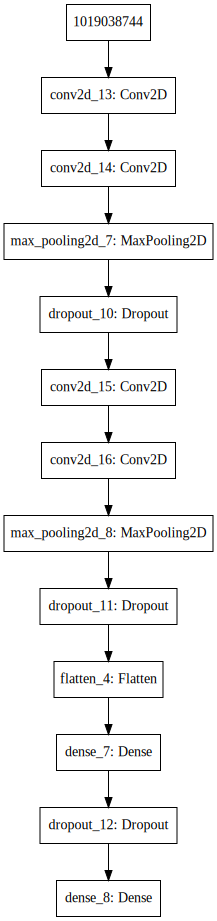

In [74]:
# bug fixes needed in keras. below code aims at correcting the call to the wrong packge, cf. https://github.com/XifengGuo/CapsNet-Keras/issues/69
# Note that you should install graphviz and set C:\...\graphviz\bin in your path
import keras
import pydot_ng
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot_ng
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Imaginons que l'on veuille créer un modèle dont le graphe n'est pas linéaire (pour certaines raison,s par exemple pour tratier des données de différents type, pour utiliser un modèle pré-entrainé par ailleurs...). 

In [76]:
# TBD

# Pour aller encore plus loin...

## Q?: Détection d'objets

[Ressource](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)